In [55]:
import pandas as pd
import numpy as np

import pydotplus
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Exploratory Data Analisys

In [56]:
hour_df = pd.read_csv("https://raw.githubusercontent.com/ftarantuviez/Analyzing-Bike-Sharing-Trends/master/Datasets/hour.csv")
print("Shape of dataset::{}".format(hour_df.shape))

Shape of dataset::(17379, 17)


In [57]:
hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [58]:
hour_df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [59]:
# make columns names more pythonistics
hour_df.rename(columns={
    "instant": "rec_id",
    "dteday": "datetime",
    "holiday": "is_holiday",
    "workingday": "is_workingday",
    "weathersit": "weather_condition",
    "hum": "humidity",
    "mnth": "month",
    "cnt": "total_count",
    "hr": "hour",
    "yr": "year"
}, inplace=True)

In [60]:
# date time conversion
hour_df["datetime"] = pd.to_datetime(hour_df.datetime)

# categorical variables
hour_df["season"] = hour_df.season.astype("category")
hour_df["is_holiday"] = hour_df.is_holiday.astype("category")
hour_df["weekday"] = hour_df.weekday.astype("category")
hour_df["weather_condition"] = hour_df.weather_condition.astype("category")
hour_df["is_workingday"] = hour_df.is_workingday.astype("category")
hour_df["month"] = hour_df.month.astype("category")
hour_df["year"] = hour_df.year.astype("category")
hour_df["hour"] = hour_df.hour.astype("category")

[Text(0.5, 1.0, 'Season wise hourly distribution of counts')]

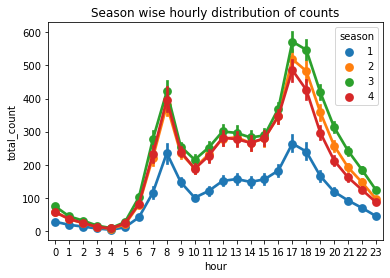

In [61]:
fig, ax = plt.subplots()
sn.pointplot(data=hour_df[["hour", "total_count", "season"]], x="hour", y="total_count", hue="season", ax=ax)
ax.set(title="Season wise hourly distribution of counts")

[Text(0.5, 1.0, 'Week wise hourly distribution of counts')]

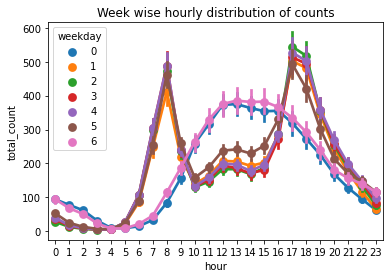

In [62]:
fig, ax = plt.subplots()
sn.pointplot(data=hour_df[["hour", "total_count", "weekday"]], x="hour", y="total_count", hue="weekday", ax=ax)
ax.set(title="Week wise hourly distribution of counts")

[Text(0.5, 1.0, 'Monthly distribution of counts')]

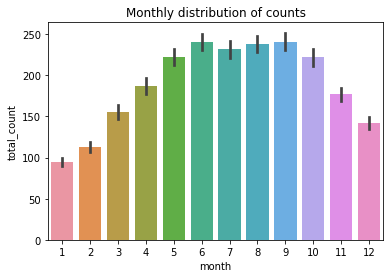

In [63]:
fig, ax = plt.subplots()
sn.barplot(data=hour_df[["month", "total_count"]], x="month", y="total_count", ax=ax)
ax.set(title="Monthly distribution of counts")

<AxesSubplot:xlabel='year', ylabel='total_count'>

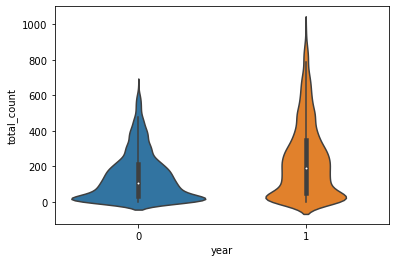

In [64]:
sn.violinplot(data=hour_df[["year", "total_count"]], x="year", y="total_count")

<AxesSubplot:>

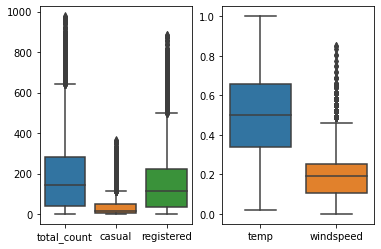

In [65]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sn.boxplot(data=hour_df[["total_count", "casual", "registered"]], ax=ax1)
sn.boxplot(data=hour_df[["temp", "windspeed"]], ax=ax2)

[Text(0.5, 1.0, 'Box plot for hourly distribution of counts')]

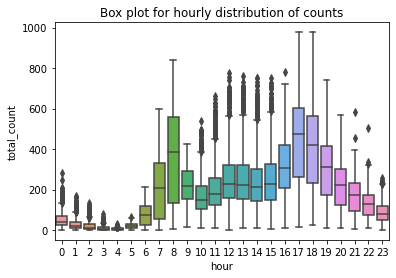

In [66]:
fig, ax = plt.subplots()
sn.boxplot(data=hour_df[["hour", "total_count"]], x="hour", y="total_count", ax=ax)
ax.set(title="Box plot for hourly distribution of counts")

<AxesSubplot:>

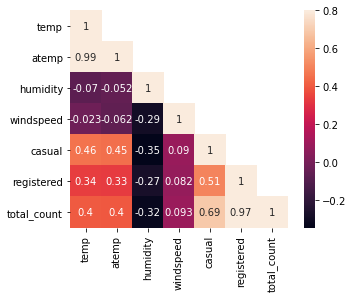

In [67]:
# Correlations
# It's important to understand that correlation does not imply causation.

corrMatt = hour_df[["temp", "atemp", "humidity", "windspeed", "casual", "registered", "total_count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
sn.heatmap(corrMatt, mask=mask, vmax=.8, square=True,annot=True)

# Regression Analysis

In [68]:
def fit_transform_ohe(df,col_name):
    """
        This function performs one hot encoding for the specified column.
        
        Args:
            df(pandas.DataFrame): the data frame containing the mentioned column name.
            col_name: the column to be one hot encoded
            
        Returns:
            tuple: label_encoder, one_hot_encoder, transformed column as pandas Series.
    """
    
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name + "_label"] = le_labels
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+"_label"]]).toarray()
    feature_labels = [col_name+"_"+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return le,ohe,features_df

In [69]:
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.
    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded
    Returns:
        tuple: transformed column as pandas Series
    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

In [70]:
X, X_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3], hour_df.iloc[:,-1], test_size=.33, random_state=42)

X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

In [71]:
cat_attr_list = ["season", "is_holiday", "weather_condition", "is_workingday", "hour", "weekday", "month", "year"]
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({
        "label_enc": return_obj[0],
        "ohe_enc": return_obj[1],
        "feature_df": return_obj[2],
        "col_name": col,
    })

In [72]:
feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc["feature_df"] \
                           for enc in encoded_attr_list \
                            if enc["col_name"] in subset_cat_features
                       ])
train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

Shape::(11643, 19)


In [100]:
hour_df.season.unique()
train_df_new

,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,is_workingday_0,is_workingday_1
0,0.64,0.65,0.1940,0,5,9,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.50,0.45,0.2239,13,2,3,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.86,0.47,0.5224,12,0,8,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.30,0.61,0.0000,2,3,2,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.54,0.19,0.4179,17,6,4,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11638,0.46,0.88,0.0896,9,5,4,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11639,0.66,0.34,0.1343,17,5,5,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11640,0.80,0.43,0.2836,12,3,8,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11641,0.24,0.65,0.4179,7,2,2,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [74]:
X = train_df_new
y = y.total_count.values.reshape(-1,1)

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X,y)

LinearRegression()

In [75]:
predicted = cross_val_predict(lin_reg, X,y,cv=10)

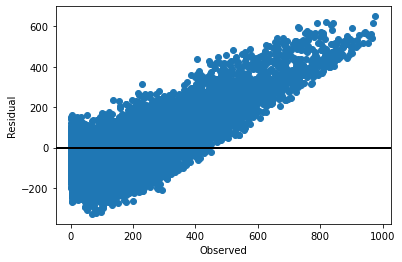

In [76]:
fig,ax=plt.subplots()
ax.scatter(y, y-predicted)
ax.axhline(lw=2,color="black")
ax.set_xlabel("Observed")
ax.set_ylabel("Residual")
plt.show()

In [77]:
r2_scores = cross_val_score(lin_reg, X, y, cv=10)
mse_scores = cross_val_score(lin_reg, X, y, cv=10,scoring='neg_mean_squared_error')

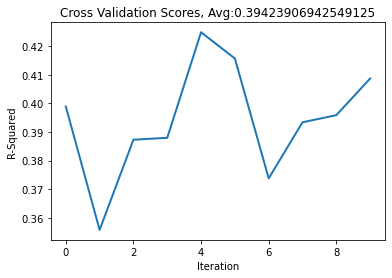

In [78]:
fig, ax = plt.subplots()
ax.plot([i for i in range(len(r2_scores))],r2_scores,lw=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('R-Squared')
ax.title.set_text("Cross Validation Scores, Avg:{}".format(np.average(r2_scores)))
plt.show()

In [79]:
print("R-squared::{}".format(r2_scores))
print("MSE::{}".format(mse_scores))

R-squared::[0.39894459 0.35575732 0.3873037  0.38796861 0.42489499 0.41571164
 0.37379762 0.39339864 0.39589746 0.40871611]
MSE::[-19612.38349313 -20800.77110185 -20256.54013607 -18545.99033804
 -18746.57816436 -21015.35560028 -21549.12876053 -21567.27946203
 -21044.42416385 -18899.05989574]


In [80]:
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc["col_name"]
    le = enc["label_enc"]
    ohe = enc["ohe_enc"]
    test_encoded_attr_list.append({
        "feature_df": transform_ohe(X_test, le, ohe, col_name),
        "col_name": col_name
    })
    
    test_feature_df_list = [X_test[numeric_feature_cols]]
    test_feature_df_list.extend([enc["feature_df"] \
                                    for enc in test_encoded_attr_list \
                                     if enc["col_name"] in subset_cat_features
                                ])
    test_df_new = pd.concat(test_feature_df_list, axis=1)
    print("Shape::{}".format(test_df_new.shape))

Shape::(5736, 11)
Shape::(5736, 13)
Shape::(5736, 17)
Shape::(5736, 19)
Shape::(5736, 19)
Shape::(5736, 19)
Shape::(5736, 19)
Shape::(5736, 19)


In [81]:
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)
y_pred = lin_reg.predict(X_test)
residuals = y_test - y_pred

In [82]:
r2_score = lin_reg.score(X_test,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f"
      % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.4024409682673429
MSE: 19063.00


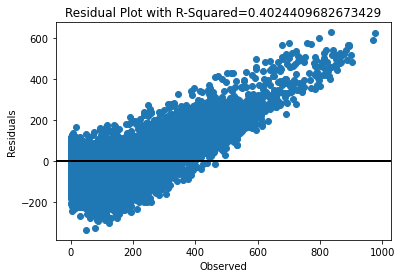

In [83]:
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2, color="black")
ax.set_xlabel("Observed")
ax.set_ylabel("Residuals")
ax.title.set_text("Residual Plot with R-Squared={}".format(np.average(r2_score)))

# Decision Tree

In [84]:
dtr = DecisionTreeRegressor(max_depth=4, min_samples_split=5, max_leaf_nodes=10)
dtr.fit(X,y)

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10, min_samples_split=5)

In [85]:
dot_data = tree.export_graphviz(dtr, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("bikeshare.pdf")

True

In [86]:
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100, 500, 800],
              }

In [87]:
grid_cv_dtr = GridSearchCV(dtr, param_grid=param_grid, cv=5)

In [88]:
grid_cv_dtr.fit(X,y)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10,
                                             min_samples_split=5),
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8],
                         'max_leaf_nodes': [5, 20, 100, 500, 800],
                         'min_samples_leaf': [20, 40, 100],
                         'min_samples_split': [10, 20, 40]})

In [96]:
print("R-Squared::{}".format(grid_cv_dtr.best_score_))
print("Best hyperparameters::{}".format(grid_cv_dtr.best_params_))
import pickle
pickle.dump(grid_cv_dtr.best_estimator_, open("tree.pkl", "wb"))

R-Squared::0.8333284746008405
Best hyperparameters::{'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 500, 'min_samples_leaf': 20, 'min_samples_split': 10}


DecisionTreeRegressor(max_depth=8, max_leaf_nodes=500, min_samples_leaf=20,
                      min_samples_split=10)

In [90]:
df = pd.DataFrame(data=grid_cv_dtr.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007564,0.002949,0.001976,0.000358,mse,2,5,20,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181
1,0.005572,0.000067,0.001598,0.000025,mse,2,5,20,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181
2,0.005508,0.000035,0.001581,0.000008,mse,2,5,20,40,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181
3,0.005597,0.000070,0.001602,0.000035,mse,2,5,40,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181
4,0.005505,0.000029,0.001576,0.000009,mse,2,5,40,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181


[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

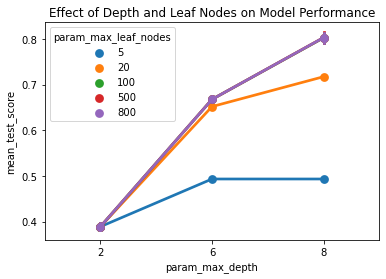

In [91]:
fig,ax = plt.subplots()
sn.pointplot(data=df[['mean_test_score',
                        'param_max_leaf_nodes',
                        'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

# Testing

In [92]:
best_dtr_model = grid_cv_dtr.best_estimator_

In [93]:
y_pred = best_dtr_model.predict(X_test)
residuals = y_test.flatten() - y_pred

In [94]:
print("R-Squared::{}".format(r2_score))

R-Squared::0.4024409682673429
